# BLIP: Inference Demo
 - [Image Captioning](#Image-Captioning)
 - [VQA](#VQA)
 - [Feature Extraction](#Feature-Extraction)
 - [Image Text Matching](#Image-Text-Matching)

In [ ]:
# # install requirements
# import sys
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
#     !git clone https://github.com/salesforce/BLIP
#     %cd BLIP

In [1]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def load_demo_image(path, image_size, device):
    if path:
         raw_image = Image.open(path).convert('RGB')
    else:
        img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
        raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w, h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device) 
    print(f'Image shape: {image.shape}')  
    return image

cuda


# Image Captioning
Perform image captioning using finetuned BLIP model

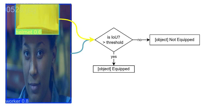

Image shape: torch.Size([1, 3, 384, 384])
reshape position embedding from 196 to 576
load checkpoint from D:\Downloads\model_base_capfilt_large.pth
Model loaded.
caption: a woman's face with a yellow box over her head


In [2]:
from models.blip import blip_decoder

image_size = 384
path = r"D:\Downloads\iou.jpg"
image = load_demo_image(path, image_size=image_size, device=device)  

model_url = "D:\Downloads\model_base_capfilt_large.pth"
    
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)
print('Model loaded.')
with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    print('caption: '+caption[0])

# VQA
Perform visual question answering using finetuned BLIP model

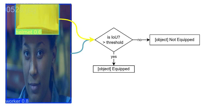

Image shape: torch.Size([1, 3, 480, 480])
reshape position embedding from 196 to 900
load checkpoint from D:\Downloads\model_base_capfilt_large.pth
answer: a black and white photo of a woman in


In [3]:
from models.blip_vqa import blip_vqa

image_size = 480
image = load_demo_image(path, image_size=image_size, device=device)     

model_url = "D:\Downloads\model_base_capfilt_large.pth"
    
model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

question = 'what is the woman wearing?'

with torch.no_grad():
    answer = model(image, question, train=False, inference='generate') 
    print('answer: '+answer[0])

# Feature Extraction

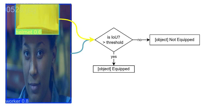

Image shape: torch.Size([1, 3, 224, 224])
load checkpoint from D:\Downloads\model_base.pth


In [2]:
from models.blip import blip_feature_extractor

image_size = 224
path = r"D:\Downloads\iou.jpg"
image = load_demo_image(path, image_size=image_size, device=device)     

model_url = "D:\Downloads\model_base.pth"
    
model = blip_feature_extractor(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'a woman sitting on the beach with a dog'

multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]

# Image-Text Matching

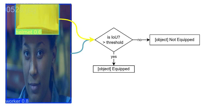

Image shape: torch.Size([1, 3, 384, 384])
load checkpoint from D:\Downloads\model_base_retrieval_coco.pth
text: a woman sitting on the beach with a dog


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [6]:
from models.blip_itm import blip_itm

image_size = 384
image = load_demo_image(path, image_size=image_size,device=device)

model_url = "D:\Downloads\model_base_retrieval_coco.pth"
    
model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device='cpu')

caption = 'a woman sitting on the beach with a dog'

print('text: %s' %caption)

itm_output = model(image,caption,match_head='itm')
itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
print('The image and text is matched with a probability of %.4f'%itm_score)

itc_score = model(image,caption,match_head='itc')
print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)

# Ngoài lề

In [1]:
import os
import argparse

def iter_tree(path, prefix="", max_depth=None, _depth=0, include_files=True):
    """
    Yield lines of a tree representation for path.
    - max_depth: None or int, maximum depth (0 = only root)
    - include_files: whether to list files (True) or only directories
    """
    if max_depth is not None and _depth > max_depth:
        return

    try:
        entries = sorted(os.scandir(path), key=lambda e: (not e.is_dir(), e.name.lower()))
    except PermissionError:
        yield prefix + "[PermissionError] " + os.path.basename(path)
        return
    except FileNotFoundError:
        yield prefix + "[NotFound] " + path
        return

    total = len(entries)
    for i, entry in enumerate(entries):
        is_last = (i == total - 1)
        connector = "└── " if is_last else "├── "
        if entry.is_dir(follow_symlinks=False):
            yield prefix + connector + entry.name + "/"
            extension = "    " if is_last else "│   "
            yield from iter_tree(entry.path, prefix + extension, max_depth, _depth + 1, include_files)
        else:
            if include_files:
                yield prefix + connector + entry.name

def print_tree(path=".", max_depth=None, include_files=True):
    path = os.path.abspath(path)
    print(path)
    for line in iter_tree(path, max_depth=max_depth, include_files=include_files):
        print(line)

if __name__ == "__main__":
    print_tree("dataset")

d:\Project\Code\BLIP\dataset
└── uitvic_dataset/
    ├── test/
    │   └── test/
    │       └── 000000000368.jpg
    ├── train/
    │   └── train/
    │       └── 000000000368.jpg
    ├── test_ann.json
    └── train_ann.json


In [16]:
from data.utils import pre_caption
caption = "cậu bé chơi với quả bóng!   "
pre_caption(caption, max_words=10)

'cậu bé chơi với quả bóng'

In [20]:
import re

def pre_caption_vietnamese(caption, max_words=50):
    """
    Xử lý trước caption phù hợp với tiếng Việt, đảm bảo không mất từ quan trọng.
    """
    # Loại bỏ các ký tự đặc biệt không cần thiết
    caption = re.sub(
        r"([\"()*#:;~])",  # Loại bỏ các ký tự không cần thiết
        ' ',
        caption.lower(),
    )
    
    # Giữ lại các dấu câu quan trọng trong tiếng Việt
    caption = re.sub(
        r"([.!?,])",  # Giữ lại các dấu câu quan trọng
        r" \1",
        caption,
    )
    
    # Loại bỏ khoảng trắng thừa
    caption = re.sub(
        r"\s{2,}",  # Thay thế khoảng trắng liên tiếp bằng một khoảng trắng
        ' ',
        caption,
    )
    
    # Loại bỏ khoảng trắng ở đầu và cuối chuỗi
    caption = caption.strip()

    # Cắt ngắn caption nếu vượt quá số từ tối đa
    caption_words = caption.split(' ')
    if len(caption_words) > max_words:
        caption = ' '.join(caption_words[:max_words])
            
    return caption

In [21]:
caption = "cậu bé chơi với quả bóng!   "
pre_caption_vietnamese(caption, max_words=10)

'cậu bé chơi với quả bóng !'